In [1]:
#Scenario 2: bistable state
#2.1.a: short simulation duration, constant target
#2.1.b: long simulation duration, constant target
#2.2.a: short simulation duration, sin target
#2.2.b: long simulation duration, sin target

In [2]:
# change to the root directory of the project
import os
if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    
path = os.getcwd()
import sys
if path not in sys.path:
    sys.path.append(path)
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

import matplotlib.pyplot as plt
import numpy as np
#import testing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Let's import the aln model
from neurolib.models.aln import ALNModel

# Some useful functions are provided here
import neurolib.utils.functions as func

aln = ALNModel()

In [4]:
def plot_rate(model, control_, target_ = None):
    aln.run( control = control_ )
    time = model['t']

    fig, ax = plt.subplots()

    ax.plot(time, model['rates_exc'].T, lw=2, c='k', label='Exc activity')
    ax.set_xlabel("t [ms]")
    ax.set_ylabel("Rate [Hz]")
    ax.set_xlim([0,model.params['duration']])
    
    if type(target_) != type(None):
        ax.plot(time, target_[0,0,:], lw=2, c='yellow', label='Target')

    #ax2 = ax.twinx()
    #ax2.plot(time, control_[0,0,:]/5., lw=1, c='red', label='Exc control')
    #ax2.plot(time, control_[0,1,:]/5., lw=1, c='blue', label='Inh control')
    #ax2.set_xlabel("t [ms]")
    #ax2.set_ylabel("Control current [nA]")

    plt.legend()
    plt.show()

down state


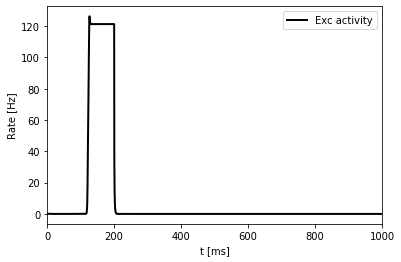

In [5]:
#initialize model

def set_aln_init_zero():
    N = aln.params.N
    aln.params.mufe_init = 0 * np.random.uniform(0, 1, (N,))  # mV/ms
    aln.params.mufi_init = 0 * np.random.uniform(0, 1, (N,))  # mV/ms
    aln.params.seem_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seim_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seev_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seiv_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siim_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siem_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siiv_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siev_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.rates_exc_init = 0. * np.random.uniform(0, 1, (N, 1))
    aln.params.rates_inh_init = 0. * np.random.uniform(0, 1, (N, 1))
    aln.params.IA_init = 0.0 * np.zeros((N, 1))  # pA
    aln.params.mue_ou = 0. * np.random.uniform(0, 1, (N,))
    aln.params.mui_ou = 0. * np.random.uniform(0, 1, (N,))

# reads final state of model dynamics
# set before simulation such that system begins in stable state
def read_state():
    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]
    return init_state_vars
    
aln = ALNModel()
set_aln_init_zero()
aln.params.a = 0. # no adaptation
aln.params.b = 0. # no adaptation
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.
aln.params['duration'] = 1000. 

control0 = aln.getZeroControl()
control0[0,0,1000:2000] = 5.
control0[0,0,5000:6000] = -5.

state_vars = aln.state_vars


# down state
print("down state")
aln.params.mue_ext_mean = 0. * 5.
aln.params.mui_ext_mean = 0.5 * 5.
    
plot_rate(aln, control0)
init_down = read_state()


In [6]:
 # to set initial parameters
def setinit(init_vars_, model):
    
    for iv in range(len(model.init_vars)):
        for sv in range(len(model.state_vars)):
            if model.state_vars[sv] in model.init_vars[iv]:
                if model.params[model.init_vars[iv]].ndim == 2:
                    model.params[model.init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[model.init_vars[iv]][0] = init_vars_[sv]

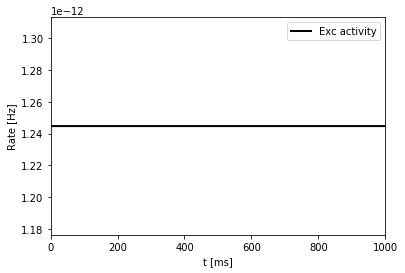

In [7]:
# fixed initialization should imply reproducibility, try also for other cases

aln = ALNModel()
set_aln_init_zero()
aln.params.a = 0. # no adaptation
aln.params.b = 0. # no adaptation
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.
aln.params['duration'] = 1000. 
aln.params.mue_ext_mean = 0. * 5.  # try also other cases parameters
aln.params.mui_ext_mean = 0.5 * 5.
setinit(init_down, aln)

control0 = aln.getZeroControl()
plot_rate(aln, control0)

In [8]:
# set parameters
tol = 1e-12 # algorithm tolerance for convergence

start_step = 10. # start step of gradient descent

c_scheme = np.zeros(( 1,1 )) # coupling scheme, only relevant for networks
c_scheme[0,0] = 1. # coupling scheme, only relevant for networks
u_mat = np.identity(1) # control matrix
u_scheme = np.array([[1.]]) # control scheme

max_it = 1000 # maximum number of iterations

max_cntrl = [5., 5., 0., 0., 0., 0.] # maximum value of control current in input nodes (exc current, inh current, rates)
min_cntrl = [-5., -5., 0., 0., 0., 0.]

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ"] # different gradient descent methods
cgv = cgv_list[0]

In [11]:
# scenario 2.1.a
# const target, short sim time
dur = 20. # simulation duration
aln.params.duration = dur
setinit(init_down, aln)

control0 = aln.getZeroControl()
control0[0,0,-100:] = 1.

target_const = aln.getZeroTarget()
target_const[0,0,:] = 50

# oscillation should be somewhat realistic, so roughly like what we find in stable oscillatory states.
# One period is roughly 40ms
target_osc = aln.getZeroTarget()
x_osc = np.arange(0.,dur+aln.params.dt,aln.params.dt)
target_osc[0,0,:] = 25. + 25. * np.sin(0.2 * x_osc)

In [14]:
#scenario 2.1.a

max_it_ = 400
cost_list_21a = []
runtime_list_21a = []
termination_it_21a = []
best_control_list_21a = []

for cgv_tmp in cgv_list:
    setinit(init_down, aln)
    bestControl, bestState, cost, runtime, gradient, adjoint, costnode = aln.A1(
        control0, target_const, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = 0., t_sim_post_ = 0., CGVar = cgv_tmp, control_variables_ = [0],
        prec_variables_ = [0], transition_time_ = 0.25)
    
    best_control_list_21a.append(bestControl)
    cost_list_21a.append(cost)
    runtime_list_21a.append(runtime)
    
    for cost_ind in range(len(cost)):
        if cost[cost_ind] == 0.:
            termination_it_21a.append(cost_ind-1)
            break

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  None
RUN  1 , total integrated cost =  18750.04139235285
RUN  2 , total integrated cost =  18750.00007782985
RUN  3 , total integrated cost =  18750.00000152694
RUN  4 , total integrated cost =  18750.000000020962
RUN  5 , total integrated cost =  18749.99999999957
RUN  6 , total integrated cost =  18749.999999999105
RUN  7 , total integrated cost =  18749.999999999094
RUN  8 , total integrated cost =  18749.99999999909
State only changes marginally.
RUN  9 , total integrated cost =  18749.99999999909
Control only changes marginally.
RUN  9 , total integrated cost =  18749.99999999909
Improved over  9  iterations in  0.1214647000000042  seconds by  0.04351320528817837  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  HS
RUN  1 , total integrated cost =  18750.04139235285
Descent direction vanishin

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


Descent direction vanishing, use standard gradient descent
RUN  5 , total integrated cost =  18749.99999999957
Descent direction vanishing, use standard gradient descent
RUN  6 , total integrated cost =  18749.999999999105
RUN  7 , total integrated cost =  18749.999999999094
Descent direction vanishing, use standard gradient descent
RUN  8 , total integrated cost =  18749.99999999909
State only changes marginally.
RUN  9 , total integrated cost =  18749.99999999909
Control only changes marginally.
RUN  9 , total integrated cost =  18749.99999999909
Improved over  9  iterations in  0.13864379999999699  seconds by  0.04351320528817837  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  FR
RUN  1 , total integrated cost =  18750.04139235285
RUN  2 , total integrated cost =  18750.00007782985
RUN  3 , total integrated cost =  18750.00007782985
Control only changes marginally.
RUN  3 , total integrated cost =  18750.0

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


 2 , total integrated cost =  18750.00007782985
RUN  3 , total integrated cost =  18750.000000042415
RUN  4 , total integrated cost =  18750.00000000047
RUN  5 , total integrated cost =  18750.00000000047
Control only changes marginally.
RUN  5 , total integrated cost =  18750.00000000047
Improved over  5  iterations in  0.10541210000000945  seconds by  0.04351320528083136  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  CD
RUN  1 , total integrated cost =  18750.04139235285
RUN  2 , total integrated cost =  18750.00007782985
RUN  3 , total integrated cost =  18750.000001819124
RUN  4 , total integrated cost =  18750.000000086337
RUN  5 , total integrated cost =  18749.99999999984
RUN  6 , total integrated cost =  18749.9999999991
RUN  7 , total integrated cost =  18749.999999999094


ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  8 , total integrated cost =  18749.99999999909
State only changes marginally.
Descent direction vanishing, use standard gradient descent
RUN  9 , total integrated cost =  18749.99999999909
Control only changes marginally.
RUN  9 , total integrated cost =  18749.99999999909
Improved over  9  iterations in  0.16849729999999852  seconds by  0.04351320528817837  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  LS
RUN  1 , total integrated cost =  18750.04139235285
RUN  2 , total integrated cost =  18750.00007782985
RUN  3 , total integrated cost =  18750.00007782985
Control only changes marginally.
RUN  3 , total integrated cost =  18750.00007782985
Improved over  3  iterations in  0.07261970000000417  seconds by  0.04351279037142319  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  DY
RUN  1 , total integrated cost =  18750.0413923528

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  5 , total integrated cost =  18749.999999999098
RUN  6 , total integrated cost =  18749.99999999909
RUN  7 , total integrated cost =  18749.99999999909
Control only changes marginally.
RUN  7 , total integrated cost =  18749.99999999909
Improved over  7  iterations in  0.15491070000000207  seconds by  0.04351320528817837  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  WYL
RUN  1 , total integrated cost =  18750.04139235285
RUN  2 , total integrated cost =  18750.00007782985
RUN  3 , total integrated cost =  18750.00007782985
Control only changes marginally.
RUN  3 , total integrated cost =  18750.00007782985
Improved over  3  iterations in  0.07603790000000288  seconds by  0.04351279037142319  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18758.16227765926
Gradient descend method:  HZ
RUN  1 , total integrated cost =  18750.04139235285
RUN  2 , total integrated cost =  

In [ ]:
for cgv_ind in range(len(cgv_list)):
    plot_rate(aln, best_control_list_21a[cgv_ind], target_const)

In [ ]:
marker_ = '.'
markersize_ = 3
linestyle_ = ''

fig, ax = plt.subplots(2, figsize=(8,8))

for i in range(len(termination_it_21a)):
    ax[0].plot(runtime_list_21a[i][:termination_it_21a[i]], cost_list_21a[i][:termination_it_21a[i]], marker=marker_,
             markersize = markersize_, linestyle=linestyle_, label = str(cgv_list[i]))
    performance = []
    for j in range(termination_it_21a[i]):
        performance.append( 100. * ( cost_list_21a[i][0] - cost_list_21a[i][j]) / cost_list_21a[i][0] ) 
    ax[1].plot(runtime_list_21a[i][:termination_it_21a[i]], performance, marker=marker_,
            markersize = markersize_, linestyle=linestyle_,
            label = str(cgv_list[i]) + ', termination at {:.2f}'.format(performance[-1]) + '% after ' + str(termination_it_21a[i]) + ' iterations' )
ax[0].legend()
ax[0].set_xlabel('Runtime [s]')
ax[0].set_ylabel('Cost')
#ax[0].title.set_text('Cost per runtime')
ax[1].legend()
ax[1].set_xlabel('Runtime [s]')
ax[1].set_ylabel('Improvement [%]')
#ax[0].title.set_text('Cost per runtime')


plt.show()

In [17]:
#scenario 2.2.a

max_it_ = 400
cost_list_22a = []
runtime_list_22a = []
termination_it_22a = []
best_control_list_22a = []

for cgv_tmp in cgv_list:
    setinit(init_down, aln)
    bestControl, bestState, cost, runtime, gradient, adjoint, costnode = aln.A1(
        control0, target_osc, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = 0., t_sim_post_ = 0., CGVar = cgv_tmp, control_variables_ = [0],
        prec_variables_ = [0], transition_time_ = 0.25)
    
    best_control_list_22a.append(bestControl)
    cost_list_22a.append(cost)
    runtime_list_22a.append(runtime)
    
    for cost_ind in range(len(cost)):
        if cost[cost_ind] == 0.:
            termination_it_22a.append(cost_ind-1)
            break

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  None
RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666482396
RUN  3 , total integrated cost =  10678.876590179485
RUN  4 , total integrated cost =  10678.876588673507
RUN  5 , total integrated cost =  10678.876588652112
RUN  6 , total integrated cost =  10678.876588651647
RUN  7 , total integrated cost =  10678.876588651638
RUN  8 , total integrated cost =  10678.876588651634
State only changes marginally.
RUN  9 , total integrated cost =  10678.876588651634
Control only changes marginally.
RUN  9 , total integrated cost =  10678.876588651634
Improved over  9  iterations in  0.12633490000000336  seconds by  0.07637548400705896  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  HS
RUN  1 , total integrated cost =  10678.917981005394
Descent directi

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


Descent direction vanishing, use standard gradient descent
RUN  4 , total integrated cost =  10678.876588673507
Descent direction vanishing, use standard gradient descent
RUN  5 , total integrated cost =  10678.876588652112
Descent direction vanishing, use standard gradient descent
RUN  6 , total integrated cost =  10678.876588651647
RUN  7 , total integrated cost =  10678.876588651638
RUN  8 , total integrated cost =  10678.876588651634
State only changes marginally.
Descent direction vanishing, use standard gradient descent
RUN  9 , total integrated cost =  10678.876588651634
Control only changes marginally.
RUN  9 , total integrated cost =  10678.876588651634
Improved over  9  iterations in  0.14574730000001068  seconds by  0.07637548400705896  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  FR
RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666482396
RUN  3 

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666482396
RUN  3 , total integrated cost =  10678.876588694959
RUN  4 , total integrated cost =  10678.876588653011
RUN  5 , total integrated cost =  10678.876588653011
Control only changes marginally.
RUN  5 , total integrated cost =  10678.876588653011
Improved over  5  iterations in  0.10445620000000133  seconds by  0.07637548399418392  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  CD
RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666482396
RUN  3 , total integrated cost =  10678.87659047167
RUN  4 , total integrated cost =  10678.87658873888
RUN  5 , total integrated cost =  10678.876588652382
RUN  6 , total integrated cost =  10678.876588651647
RUN  7 , total integrated cost =  10678.876588651636


ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  8 , total integrated cost =  10678.876588651634
Control only changes marginally.
RUN  8 , total integrated cost =  10678.876588651634
Improved over  8  iterations in  0.13522729999999683  seconds by  0.07637548400705896  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  LS
RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666482396
RUN  3 , total integrated cost =  10678.876666482396
Control only changes marginally.
RUN  3 , total integrated cost =  10678.876666482396
Improved over  3  iterations in  0.0789120999999966  seconds by  0.07637475573460506  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  DY
RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666482396
RUN  3 , total integrated cost =  10678.876588665502
RUN  4 , total integrated 

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control
ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  6 , total integrated cost =  10678.876588651634
State only changes marginally.
RUN  7 , total integrated cost =  10678.876588651634
Control only changes marginally.
RUN  7 , total integrated cost =  10678.876588651634
Improved over  7  iterations in  0.17550119999999936  seconds by  0.07637548400705896  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  WYL
RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666482396
RUN  3 , total integrated cost =  10678.876666482396
Control only changes marginally.
RUN  3 , total integrated cost =  10678.876666482396
Improved over  3  iterations in  0.07499690000000214  seconds by  0.07637475573460506  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10687.038866311803
Gradient descend method:  HZ
RUN  1 , total integrated cost =  10678.917981005394
RUN  2 , total integrated cost =  10678.876666

In [ ]:
for cgv_ind in range(len(cgv_list)):
    plot_rate(aln, best_control_list_22a[cgv_ind], target_osc)

In [ ]:
marker_ = '.'
markersize_ = 3
linestyle_ = ''

fig, ax = plt.subplots(2, figsize=(8,8))

for i in range(len(termination_it_22a)):
    ax[0].plot(runtime_list_22a[i][:termination_it_22a[i]], cost_list_22a[i][:termination_it_22a[i]], marker=marker_,
             markersize = markersize_, linestyle=linestyle_, label = str(cgv_list[i]))
    performance = []
    for j in range(termination_it_22a[i]):
        performance.append( 100. * ( cost_list_22a[i][0] - cost_list_22a[i][j]) / cost_list_22a[i][0] ) 
    ax[1].plot(runtime_list_22a[i][:termination_it_22a[i]], performance, marker=marker_,
            markersize = markersize_, linestyle=linestyle_,
            label = str(cgv_list[i]) + ', termination at {:.2f}'.format(performance[-1]) + '% after ' + str(termination_it_22a[i]) + ' iterations' )
ax[0].legend()
ax[0].set_xlabel('Runtime [s]')
ax[0].set_ylabel('Cost')
#ax[0].title.set_text('Cost per runtime')
ax[1].legend()
ax[1].set_xlabel('Runtime [s]')
ax[1].set_ylabel('Improvement [%]')
#ax[0].title.set_text('Cost per runtime')


plt.show()